# Amazon Web Scraping
## JBL FLIP 3 review scraping

![jbl-flip-3](jbl-flip-3.png)


<hr>

In [33]:
# importing all the Libraries required: 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from IPython.display import Image
from pprint import pprint as pp
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

### Fetching of DATA

_To analysis the reviews of `Jbl Flip 3` first we neeed to fetch the data required form the Amazon Web-site after that we will start our visiualization of the data and draw conclusions from it._ 

In [4]:
#code to fetch data from amazon web-site
p = 1
stars = []
reviews = []
names = []
while True:
    head1 = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.2.0.1707 Safari/537.36'}
    url_all = f"https://www.amazon.in/JBL-Stealth-Waterproof-Portable-Bluetooth/product-reviews/B07HHHMWQG/ref=cm_cr_arp_d_paging_btm_next_{p}?ie=UTF8&reviewerType=all_reviews&pageNumber={p}"
    data = requests.get(url_all, headers = head1)
    if data.status_code == 200:
        soup = BeautifulSoup(data.content)
        
        next_p = soup.find_all('li' ,{'class':'a-last'}) 
        n = soup.find_all('span' ,{'class':"a-profile-name"})
        s = soup.find_all('i', {'data-hook':"review-star-rating"})
        rev = soup.find_all('a',{'data-hook':"review-title"})
        
        for i in s:
            stars.append(i.text)
        
        for i in rev:
            reviews.append(i.text.strip())
        for i in n[2:]:
            names.append(i.text.strip())
            
        #print(f'loop ran for {p} time')            
        
    else:
        print('*'*20)
        print('something went wrong \nAt p = ',p)
        print( 'error: ',data.status_code)
        break
    
    if next_p:
        p += 1
    else:
        print('Done page no:',p)
        break
    
else:
    print('All pages done')
    
        
df = pd.DataFrame({
    'names':names,
    'stars':stars,
    'reviews':reviews
})     

    


Done page no: 412


In [5]:
#checking the no. of rows we have in each coloumn
print(len(stars),len(reviews),len(names))

4103 4103 4103


In [6]:
df.head(10)

,names,stars,reviews
0,Nzan Vin Ngullie,5.0 out of 5 stars,Kindly note this is JBL flip 3 Se (Stealth Edi...
1,AMIT SINGH CHAUHAN,5.0 out of 5 stars,Wow sound
2,Amazon Customer,5.0 out of 5 stars,Looks like an original product!
3,vipendra khanal,1.0 out of 5 stars,Totally not satisfied with Amazon services - c...
4,AMAZON_PRIME_MEMBER,1.0 out of 5 stars,Very disappointed with Amazon Service!
5,Delton Dcunha,5.0 out of 5 stars,Absolutely 5star
6,Nikhil john,5.0 out of 5 stars,Product Is Gud.But.....
7,ProfessorAb,4.0 out of 5 stars,Nice portable Bluetooth speaker without mic
8,Raj Bhardwaj,1.0 out of 5 stars,Totally fake trust.
9,vijay,5.0 out of 5 stars,Great sound with Good bass


In [169]:
#saving Dataframe in csv file 
df.to_csv('Amazon_jbl_reviews.csv')

In [8]:
#loading file from folder for analysis:
file = pd.read_csv("Amazon_jbl_reviews.csv" , index_col= "Unnamed: 0")
file

,names,stars,reviews
0,Nzan Vin Ngullie,5.0 out of 5 stars,Kindly note this is JBL flip 3 Se (Stealth Edi...
1,AMIT SINGH CHAUHAN,5.0 out of 5 stars,Wow sound
2,Amazon Customer,5.0 out of 5 stars,Looks like an original product!
3,vipendra khanal,1.0 out of 5 stars,Totally not satisfied with Amazon services - c...
4,AMAZON_PRIME_MEMBER,1.0 out of 5 stars,Very disappointed with Amazon Service!
...,...,...,...
4098,ASHISHKUMAAR B FUTANE,4.0 out of 5 stars,Fab quality
4099,Roshan Lal Vishwakarma,5.0 out of 5 stars,JBL
4100,KamalRaj,5.0 out of 5 stars,Impressive
4101,suraj das,2.0 out of 5 stars,Nice one


<hr>

### Sentiment Analysis

_Before starting our analysis we should know what kind of data we have with us._

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4103 entries, 0 to 4102
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   names    4103 non-null   object
 1   stars    4103 non-null   object
 2   reviews  4103 non-null   object
dtypes: object(3)
memory usage: 96.3+ KB


In [10]:
df.isna().sum()

names      0
stars      0
reviews    0
dtype: int64

In [11]:
df.describe()

,names,stars,reviews
count,4103,4103,4103
unique,3485,5,2404
top,Amazon Customer,5.0 out of 5 stars,Good
freq,402,2855,267


<hr>

_Lets start with finding the `Polarity` & `Subjetivity` of `reviews`_

__`Polarity`__: It simply means emotions expressed in a sentence.
            It is float which lies in the range of [-1,1] where 1 means positive statement and                  -1 means a negative statement. 
            
__`Subjetivity`__: Subjective sentence expresses some personal feelings, views, or beliefs.
               Generally refer to personal opinion, emotion or judgment whereas objective refers to                  factual information. Subjectivity is also a float which lies in the range of [0,1]

In [12]:
# func to find polarity and subjectivity

def get_polarity(text):
    return TextBlob(str(text)).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(str(text)).sentiment.subjectivity

In [13]:
df['polarity'] = df['reviews'].apply(get_polarity)
df['subjectivity'] = df['reviews'].apply(get_subjectivity)

In [14]:
df.head(10)

,names,stars,reviews,polarity,subjectivity
0,Nzan Vin Ngullie,5.0 out of 5 stars,Kindly note this is JBL flip 3 Se (Stealth Edi...,0.60000,0.9000
1,AMIT SINGH CHAUHAN,5.0 out of 5 stars,Wow sound,0.25000,0.7000
2,Amazon Customer,5.0 out of 5 stars,Looks like an original product!,0.46875,0.7500
3,vipendra khanal,1.0 out of 5 stars,Totally not satisfied with Amazon services - c...,-0.25000,1.0000
4,AMAZON_PRIME_MEMBER,1.0 out of 5 stars,Very disappointed with Amazon Service!,-1.00000,0.9750
5,Delton Dcunha,5.0 out of 5 stars,Absolutely 5star,0.20000,0.9000
6,Nikhil john,5.0 out of 5 stars,Product Is Gud.But.....,0.00000,0.0000
7,ProfessorAb,4.0 out of 5 stars,Nice portable Bluetooth speaker without mic,0.60000,1.0000
8,Raj Bhardwaj,1.0 out of 5 stars,Totally fake trust.,-0.50000,1.0000
9,vijay,5.0 out of 5 stars,Great sound with Good bass,0.43750,0.5625


_Here we have the polarity and subjectivity of the our reviews now lets divide the polarity into `Positive`, `Nutral` & `Negative`_

In [15]:
def review_type(text):
    
    
    if text > 0:
        return 'Positive'
    elif text == 0:
        return 'Nutral'
    else:
        return 'Negative'

In [16]:
df['Pol_Analysis'] = df['polarity'].apply(review_type)

In [17]:
df.head(10)

,names,stars,reviews,polarity,subjectivity,Pol_Analysis
0,Nzan Vin Ngullie,5.0 out of 5 stars,Kindly note this is JBL flip 3 Se (Stealth Edi...,0.60000,0.9000,Positive
1,AMIT SINGH CHAUHAN,5.0 out of 5 stars,Wow sound,0.25000,0.7000,Positive
2,Amazon Customer,5.0 out of 5 stars,Looks like an original product!,0.46875,0.7500,Positive
3,vipendra khanal,1.0 out of 5 stars,Totally not satisfied with Amazon services - c...,-0.25000,1.0000,Negative
4,AMAZON_PRIME_MEMBER,1.0 out of 5 stars,Very disappointed with Amazon Service!,-1.00000,0.9750,Negative
5,Delton Dcunha,5.0 out of 5 stars,Absolutely 5star,0.20000,0.9000,Positive
6,Nikhil john,5.0 out of 5 stars,Product Is Gud.But.....,0.00000,0.0000,Nutral
7,ProfessorAb,4.0 out of 5 stars,Nice portable Bluetooth speaker without mic,0.60000,1.0000,Positive
8,Raj Bhardwaj,1.0 out of 5 stars,Totally fake trust.,-0.50000,1.0000,Negative
9,vijay,5.0 out of 5 stars,Great sound with Good bass,0.43750,0.5625,Positive


_From `Pol_Analysis` we come to know who all are writing comments in Possitive & Negative side_

_Finding out how many are Positive, Nutral & Negative reviews according to the Polarity_

__`reviews analysis`__

In [18]:
Pve = 0
Neu = 0
Nve = 0
for i in df["Pol_Analysis"]:
    if i == "Positive":
        Pve +=1
    elif i == "Negative":
        Nve +=1 
    else:
        Neu +=1
        
print(f"Positive reviews: {Pve},  \nNutral reviews: {Neu}, \nNegetive reviews: {Nve}")
    

Positive reviews: 2818,  
Nutral reviews: 1064, 
Negetive reviews: 221


<hr>

_Lets analysis the stars_

__`Star analysis`__

_Here I'm considering_

`4 and above` stars as `Satisfied`

` 3 ` stars as `Dont_Know`       

`below 3` stars as `Not_Satisfied`

In [19]:
st = df['stars']
stars = []
for i in st:
    stars.append(int(i[:1]))


In [20]:
star_analysis = []
for i in stars:
    if i >= 4:
        star_analysis.append('Satisfied')
    elif i < 3:
        star_analysis.append('Not_Satisfied')
    else:
        star_analysis.append('Dont_Know')

In [21]:
df["stars_analysis"] = star_analysis

In [22]:
df.head(10)

,names,stars,reviews,polarity,subjectivity,Pol_Analysis,stars_analysis
0,Nzan Vin Ngullie,5.0 out of 5 stars,Kindly note this is JBL flip 3 Se (Stealth Edi...,0.60000,0.9000,Positive,Satisfied
1,AMIT SINGH CHAUHAN,5.0 out of 5 stars,Wow sound,0.25000,0.7000,Positive,Satisfied
2,Amazon Customer,5.0 out of 5 stars,Looks like an original product!,0.46875,0.7500,Positive,Satisfied
3,vipendra khanal,1.0 out of 5 stars,Totally not satisfied with Amazon services - c...,-0.25000,1.0000,Negative,Not_Satisfied
4,AMAZON_PRIME_MEMBER,1.0 out of 5 stars,Very disappointed with Amazon Service!,-1.00000,0.9750,Negative,Not_Satisfied
5,Delton Dcunha,5.0 out of 5 stars,Absolutely 5star,0.20000,0.9000,Positive,Satisfied
6,Nikhil john,5.0 out of 5 stars,Product Is Gud.But.....,0.00000,0.0000,Nutral,Satisfied
7,ProfessorAb,4.0 out of 5 stars,Nice portable Bluetooth speaker without mic,0.60000,1.0000,Positive,Satisfied
8,Raj Bhardwaj,1.0 out of 5 stars,Totally fake trust.,-0.50000,1.0000,Negative,Not_Satisfied
9,vijay,5.0 out of 5 stars,Great sound with Good bass,0.43750,0.5625,Positive,Satisfied


In [23]:
#saving Dataframe in csv file 
df.to_csv('Amazon_jbl_reviews.csv')

In [24]:
#loading file from folder for analysis:
file = pd.read_csv("Amazon_jbl_reviews.csv" , index_col= "Unnamed: 0")
file

,names,stars,reviews,polarity,subjectivity,Pol_Analysis,stars_analysis
0,Nzan Vin Ngullie,5.0 out of 5 stars,Kindly note this is JBL flip 3 Se (Stealth Edi...,0.60000,0.900,Positive,Satisfied
1,AMIT SINGH CHAUHAN,5.0 out of 5 stars,Wow sound,0.25000,0.700,Positive,Satisfied
2,Amazon Customer,5.0 out of 5 stars,Looks like an original product!,0.46875,0.750,Positive,Satisfied
3,vipendra khanal,1.0 out of 5 stars,Totally not satisfied with Amazon services - c...,-0.25000,1.000,Negative,Not_Satisfied
4,AMAZON_PRIME_MEMBER,1.0 out of 5 stars,Very disappointed with Amazon Service!,-1.00000,0.975,Negative,Not_Satisfied
...,...,...,...,...,...,...,...
4098,ASHISHKUMAAR B FUTANE,4.0 out of 5 stars,Fab quality,0.00000,0.000,Nutral,Satisfied
4099,Roshan Lal Vishwakarma,5.0 out of 5 stars,JBL,0.00000,0.000,Nutral,Satisfied
4100,KamalRaj,5.0 out of 5 stars,Impressive,1.00000,1.000,Positive,Satisfied
4101,suraj das,2.0 out of 5 stars,Nice one,0.60000,1.000,Positive,Not_Satisfied


In [26]:
df.describe

<bound method NDFrame.describe of                        names               stars  \
0           Nzan Vin Ngullie  5.0 out of 5 stars   
1         AMIT SINGH CHAUHAN  5.0 out of 5 stars   
2            Amazon Customer  5.0 out of 5 stars   
3            vipendra khanal  1.0 out of 5 stars   
4        AMAZON_PRIME_MEMBER  1.0 out of 5 stars   
...                      ...                 ...   
4098   ASHISHKUMAAR B FUTANE  4.0 out of 5 stars   
4099  Roshan Lal Vishwakarma  5.0 out of 5 stars   
4100                KamalRaj  5.0 out of 5 stars   
4101               suraj das  2.0 out of 5 stars   
4102         Amazon Customer  5.0 out of 5 stars   

                                                reviews  polarity  \
0     Kindly note this is JBL flip 3 Se (Stealth Edi...   0.60000   
1                                             Wow sound   0.25000   
2                       Looks like an original product!   0.46875   
3     Totally not satisfied with Amazon services - c...  -0.25000

In [27]:
df.describe()

,polarity,subjectivity
count,4103.000000,4103.000000
mean,0.443726,0.506402
std,0.414953,0.369760
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.550000,0.600000
75%,0.700000,0.780000
max,1.000000,1.000000


<hr>

__`Visualizing the reviews`__

In [43]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelsize'] = 10


In [69]:
def show_text(ax, fs=10,):
    m_h = 0
    heights = [ b.get_height() for b in ax.patches]
    max_height = max(heights)
    pad = max_height*0.3
    text_pad = max_height*0.1
    for box in ax.patches:
        x = box.get_x()
        x += (box.get_width()/2)-0.1
        y = box.get_height()
        ax.text(x, y+text_pad, box.get_height(),
         fontsize=fs)
        #box.set_color(c)
        ax.set_ylim([0, max_height+pad])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

__We plot here Pol_Analysis to visualise it__

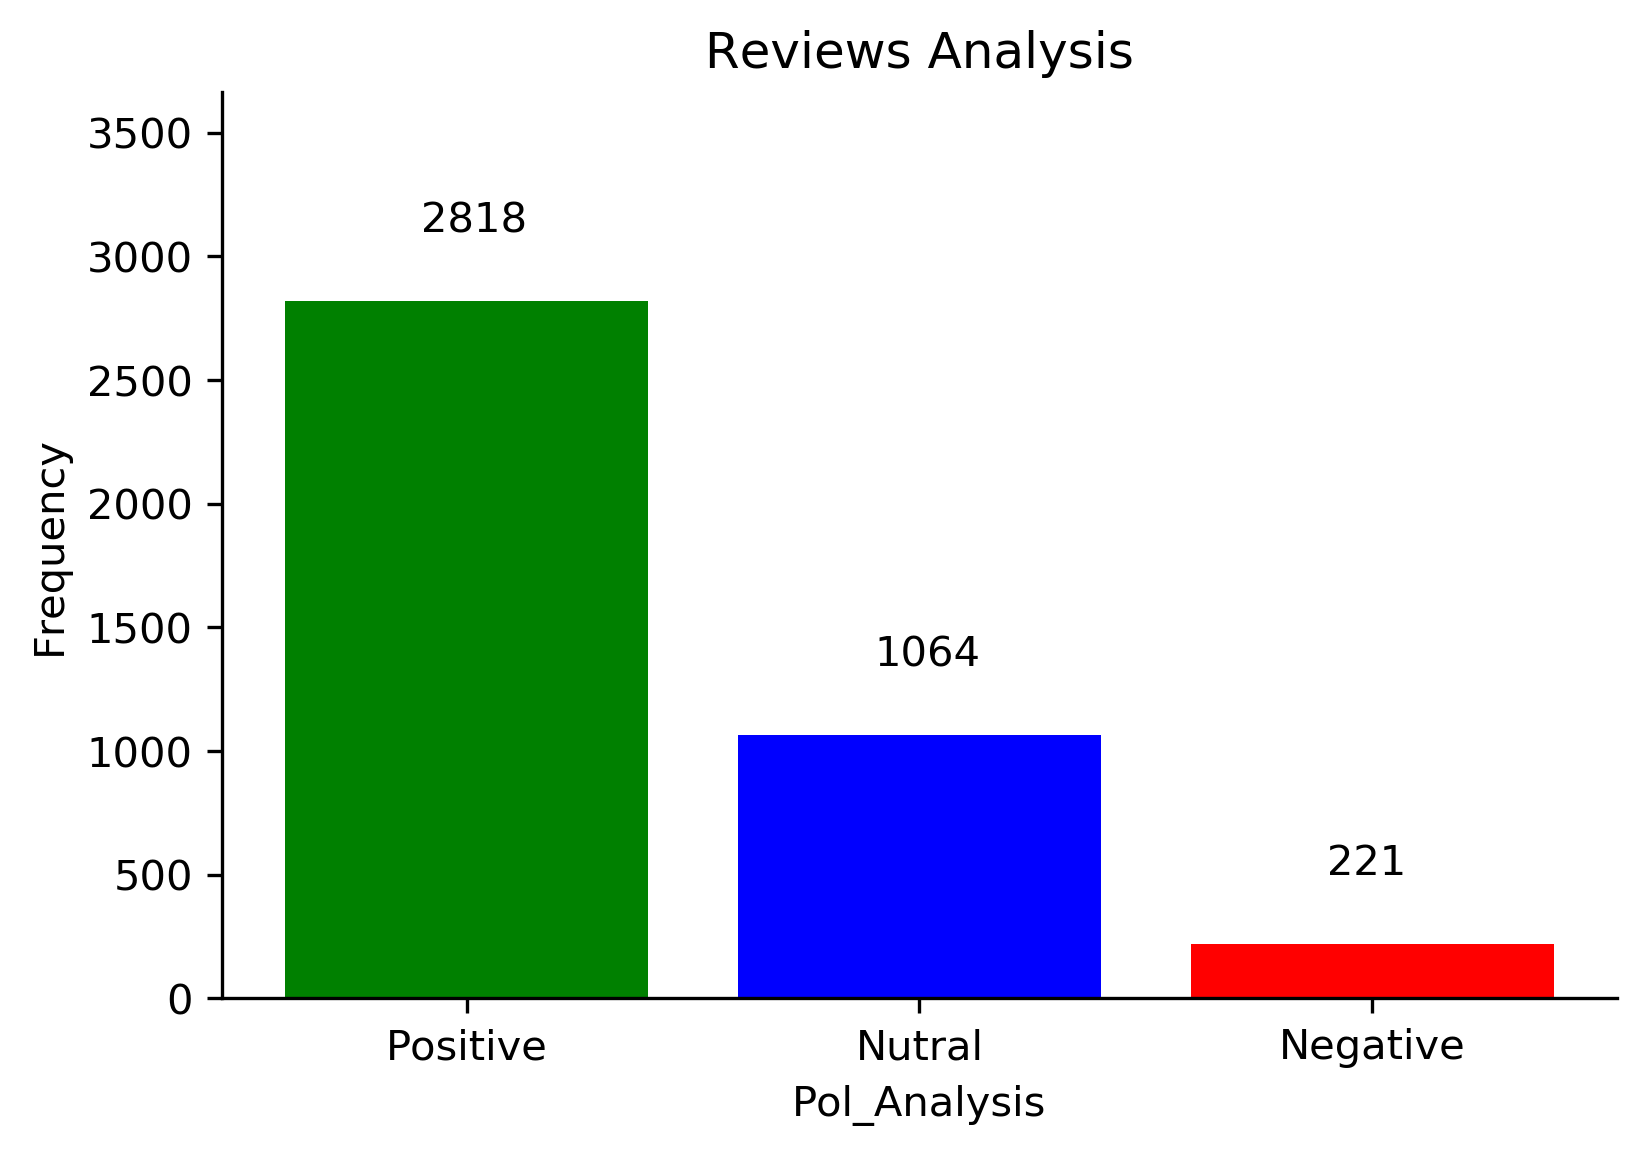

In [72]:
data = df['Pol_Analysis'].value_counts() # category
label = list(data.index)
freq = data.values
fig, ax = plt.subplots()
ax.bar(label, freq, color = 'gbr')
ax.set_xlabel('Pol_Analysis')
ax.set_ylabel('Frequency')
plt.title('Reviews Analysis')
show_text(ax)
plt.show()


From the above graph we come to know that very less people are not happy with the product.

__`Visualizing the stars`__

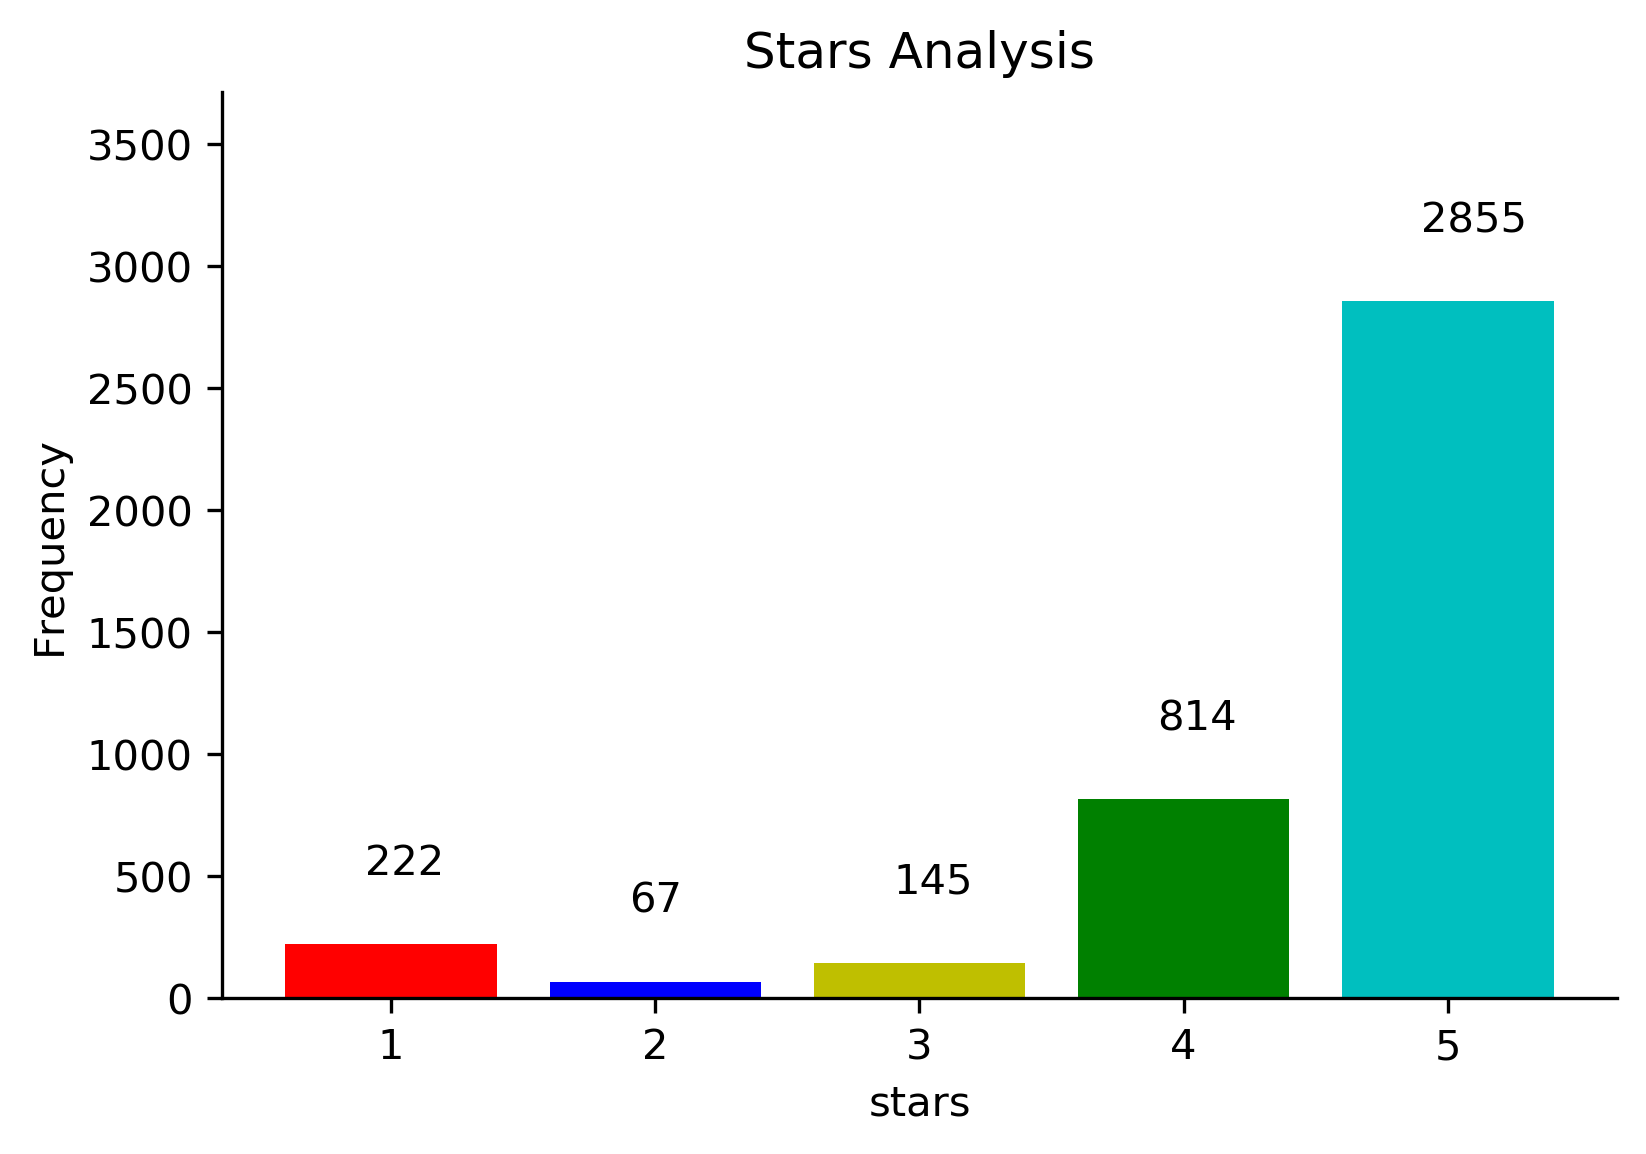

In [71]:
data = list(set(stars))
fre = [stars.count(1),stars.count(2),stars.count(3),stars.count(4),stars.count(5)]
fig, ax = plt.subplots()
ax.bar(data, fre, color = 'rbygc')
ax.set_xlabel('stars')
ax.set_ylabel('Frequency')
plt.title('Stars Analysis')
show_text(ax)
plt.show()

From the above graph we can clearly visualize the stars

__`Comparission between Pol_Analysis and Star_Analysis`__

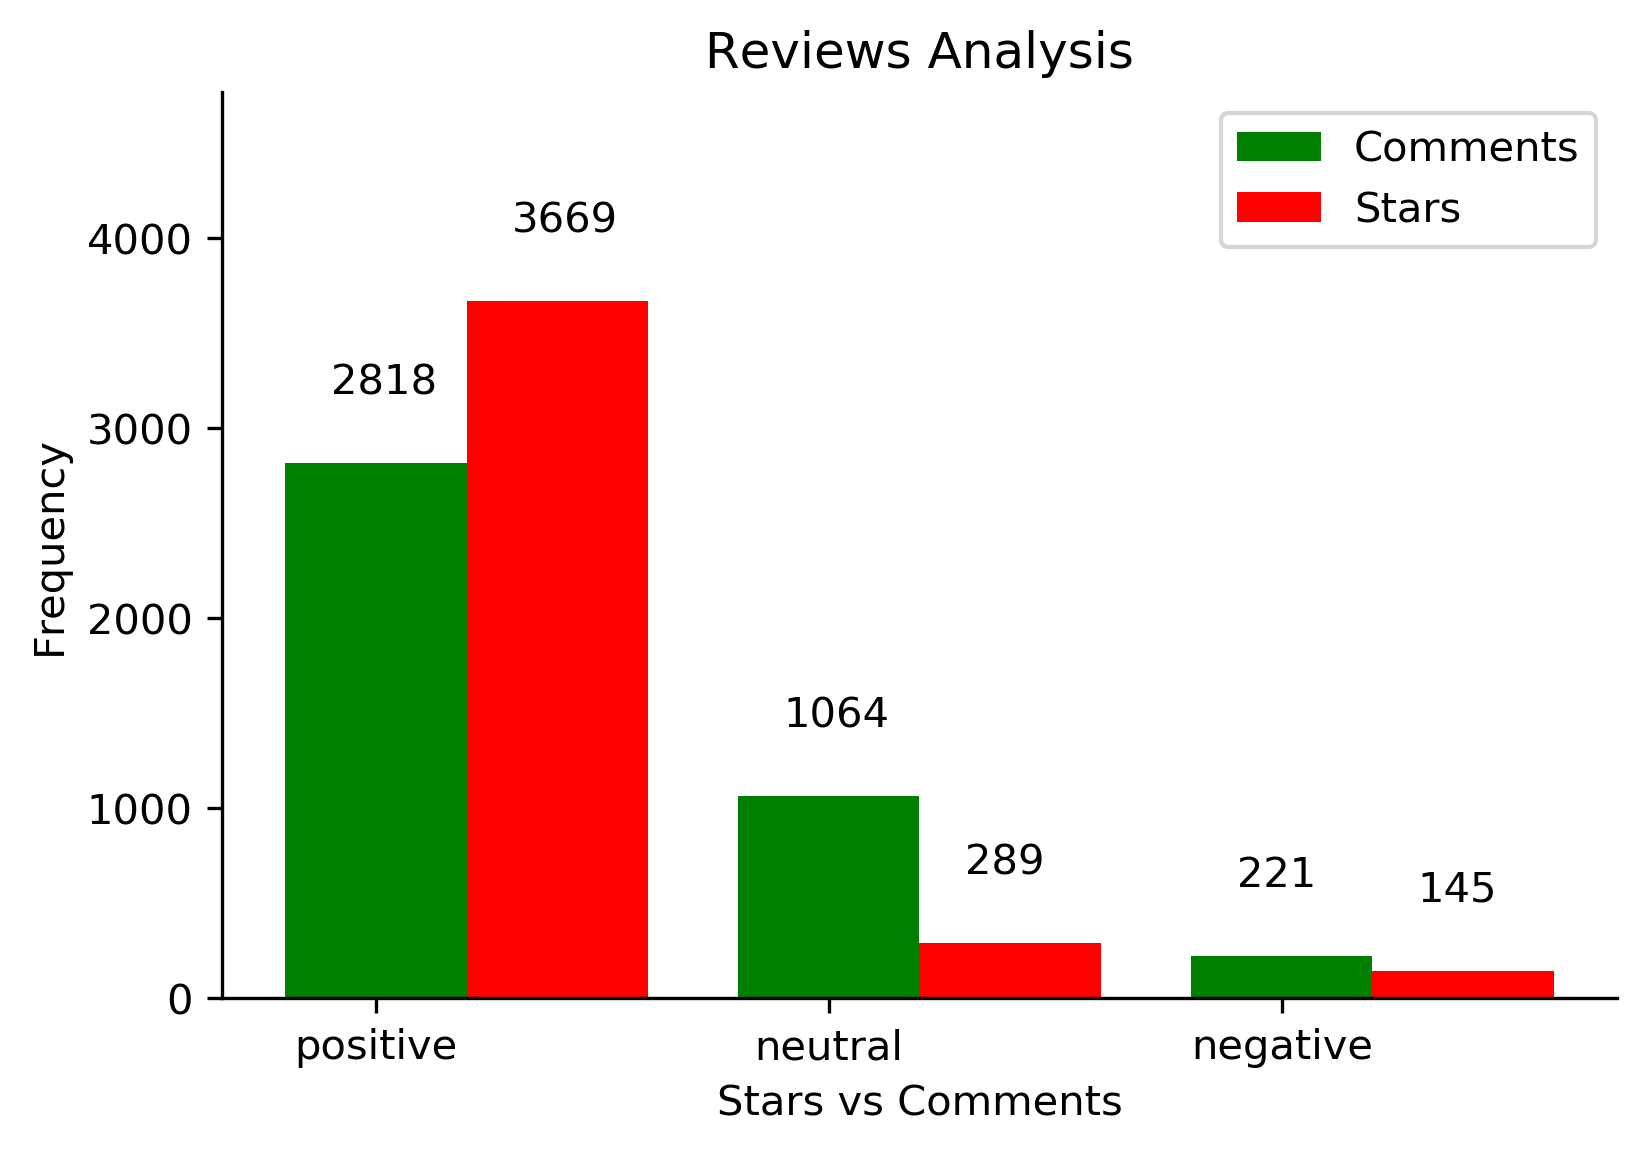

In [75]:
data = df['Pol_Analysis'].value_counts() # category 
data2 = df["stars_analysis"].value_counts()
freq = np.array(data.values)
freq2 = np.array(data2.values)
inp_n = np.array(['positive', "neutral", "negative"])
inp = np.arange(3)
fig, ax = plt.subplots()
ax.bar(inp, freq, color = 'g', label ='Comments', width = 0.4)
ax.bar(inp + 0.4 , freq2, color = 'r', label = 'Stars', width = 0.4)
ax.set_xlabel('Stars vs Comments')
ax.set_ylabel('Frequency')
plt.xticks(inp , inp_n  )
plt.legend()
plt.title('Reviews Analysis')
show_text(ax)
plt.show()


From the above graph we can conclude that from stars we can understand better than what we understand from comments and have better/easier visualization  

__`Finding relation between Polarity and Subjectivity`__

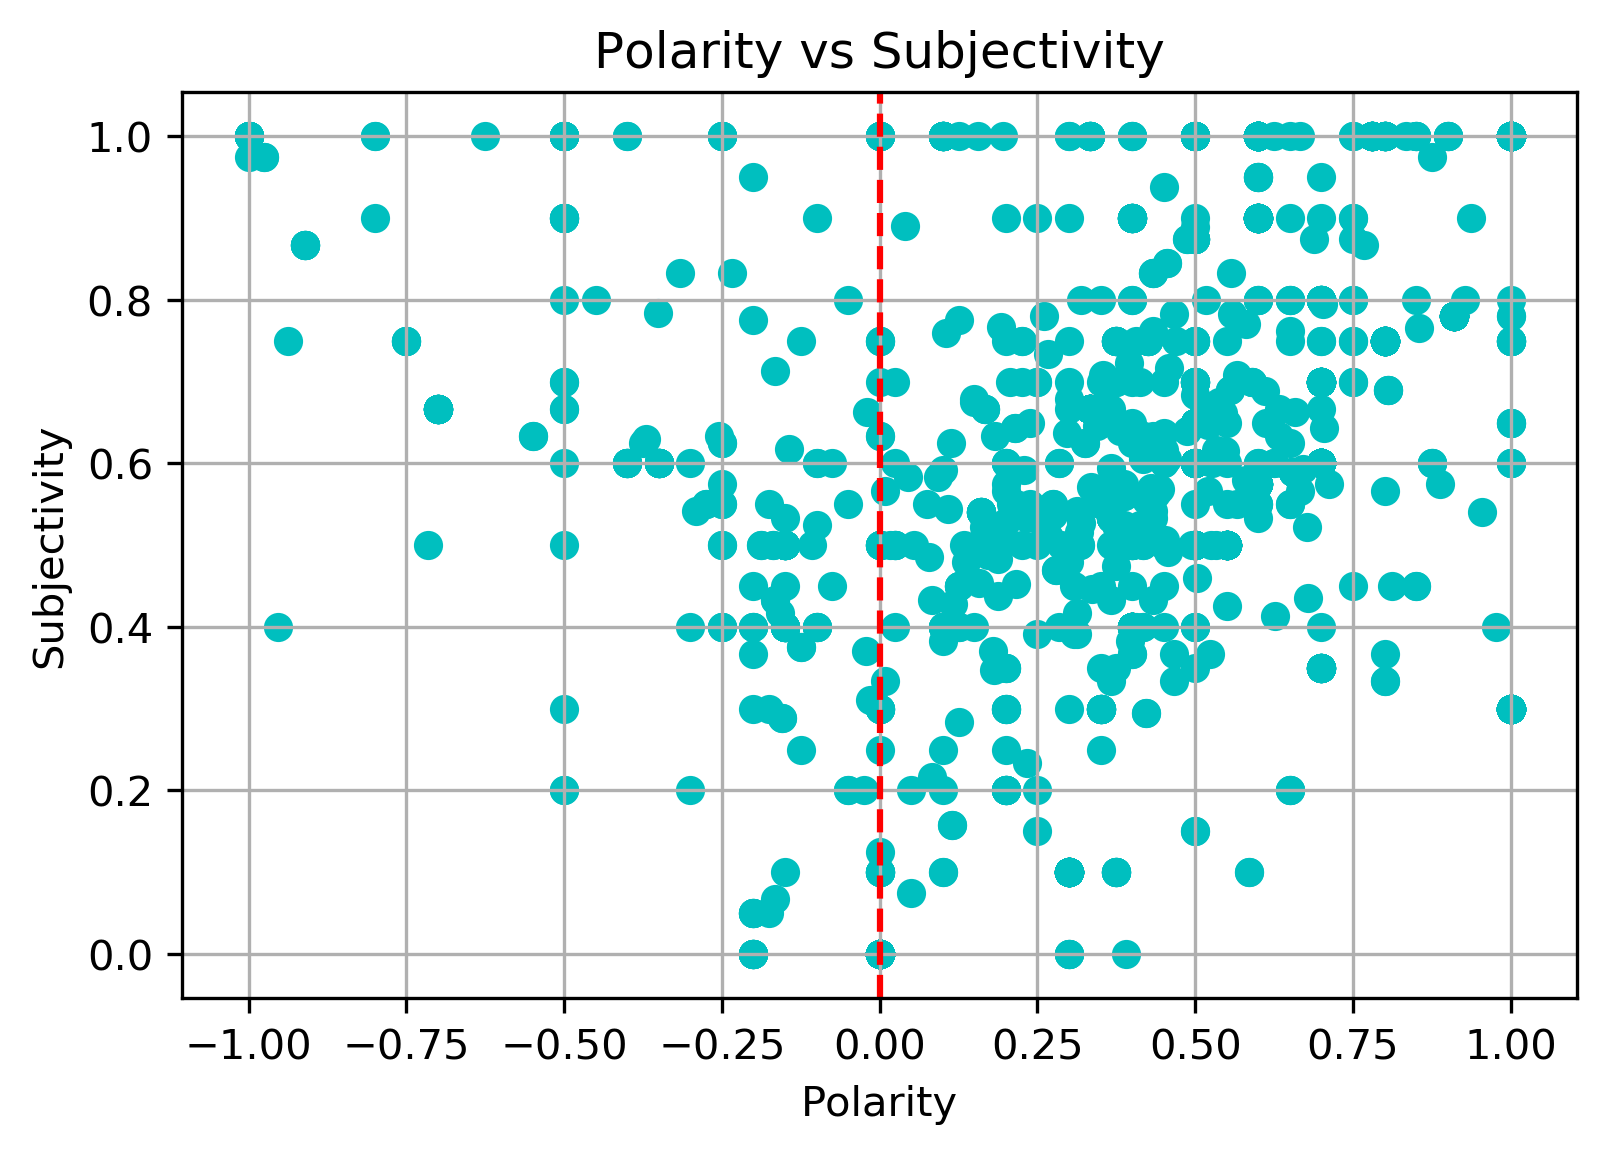

In [78]:
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], df['subjectivity'][i] ,color = "c")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.title("Polarity vs Subjectivity")
plt.axvline(np.array(0), color='r', linestyle='--')
plt.grid()
plt.show()

Here we find out that Polarity and Subjectivity have a `Positive` relation and max people have written good about it

__`Finding relation between Polarity and Stars`__

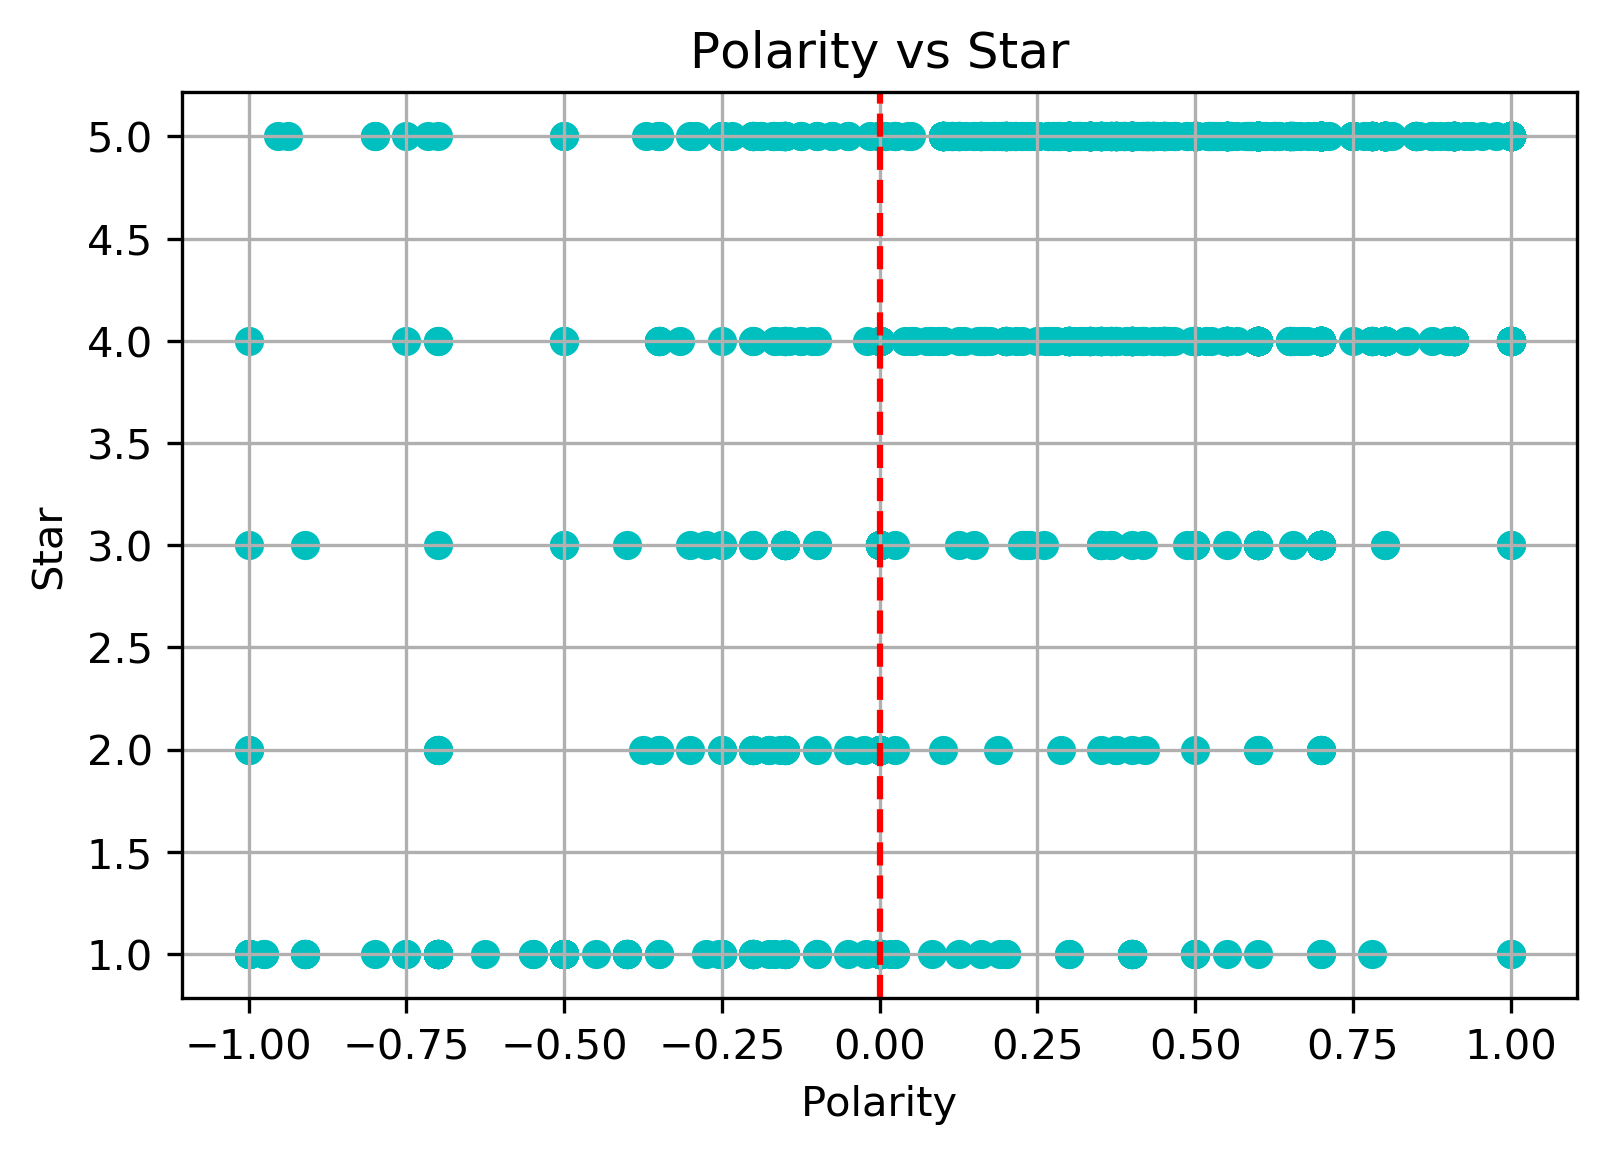

In [80]:
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], stars[i] ,color = "c")
plt.xlabel("Polarity")
plt.ylabel("Star")
plt.title("Polarity vs Star")
plt.axvline(np.array(0), color='r', linestyle='--')
plt.grid()
plt.show()

Here we see that we have highest density at 5th and 4th stars in positive side of the polarity 

From all the above analysis we can see that maximum comments and star analysis point out that most people are highly satisfied with the product

<hr>

__`Word-Cloud`__

Lets analyse reviews with Word Cloud

In [114]:
rev = df["reviews"]
rev[:20]

0     Kindly note this is JBL flip 3 Se (Stealth Edi...
1                                             Wow sound
2                       Looks like an original product!
3     Totally not satisfied with Amazon services - c...
4                Very disappointed with Amazon Service!
5                                      Absolutely 5star
6                               Product Is Gud.But.....
7           Nice portable Bluetooth speaker without mic
8                                   Totally fake trust.
9                            Great sound with Good bass
10                         Good product in decent price
11                                   Happy at first day
12               Best Genuine Product @ best deal price
13    Cannot connect with iOS or Android apps to con...
14                                JBL Connect Flip 3 SE
15    Go ahead, if JBL connect is not a priority!! F...
16                             Great for the most part.
17                     Very very good Bluetooth 

<hr>

__Cleaning reviews__

In [116]:
# spliting all the reviews for easy scraping
reviews_analysis = []
for i in rev:
    
    reviews_analysis.append(str(i).strip().split())
    

In [165]:
# cleaning the text
scrap = ["Product","product","by","A","as","you","its","it","flip3","buy","battery","from", "my","at","is","a", "an", "the", "jbl","Jbl", "JBL", "flip", "Flip", "3", "this", "This", "that", "with", "for", "and", "if", "or","them","to","of","in", "product"]
for i in scrap:
    for j in reviews_analysis:
        if i in list(set(j)):
            j.remove(i)
            
        

In [166]:
r = np.array(reviews_analysis)

In [167]:
all_words = " ".join([str(comm) for comm in r])

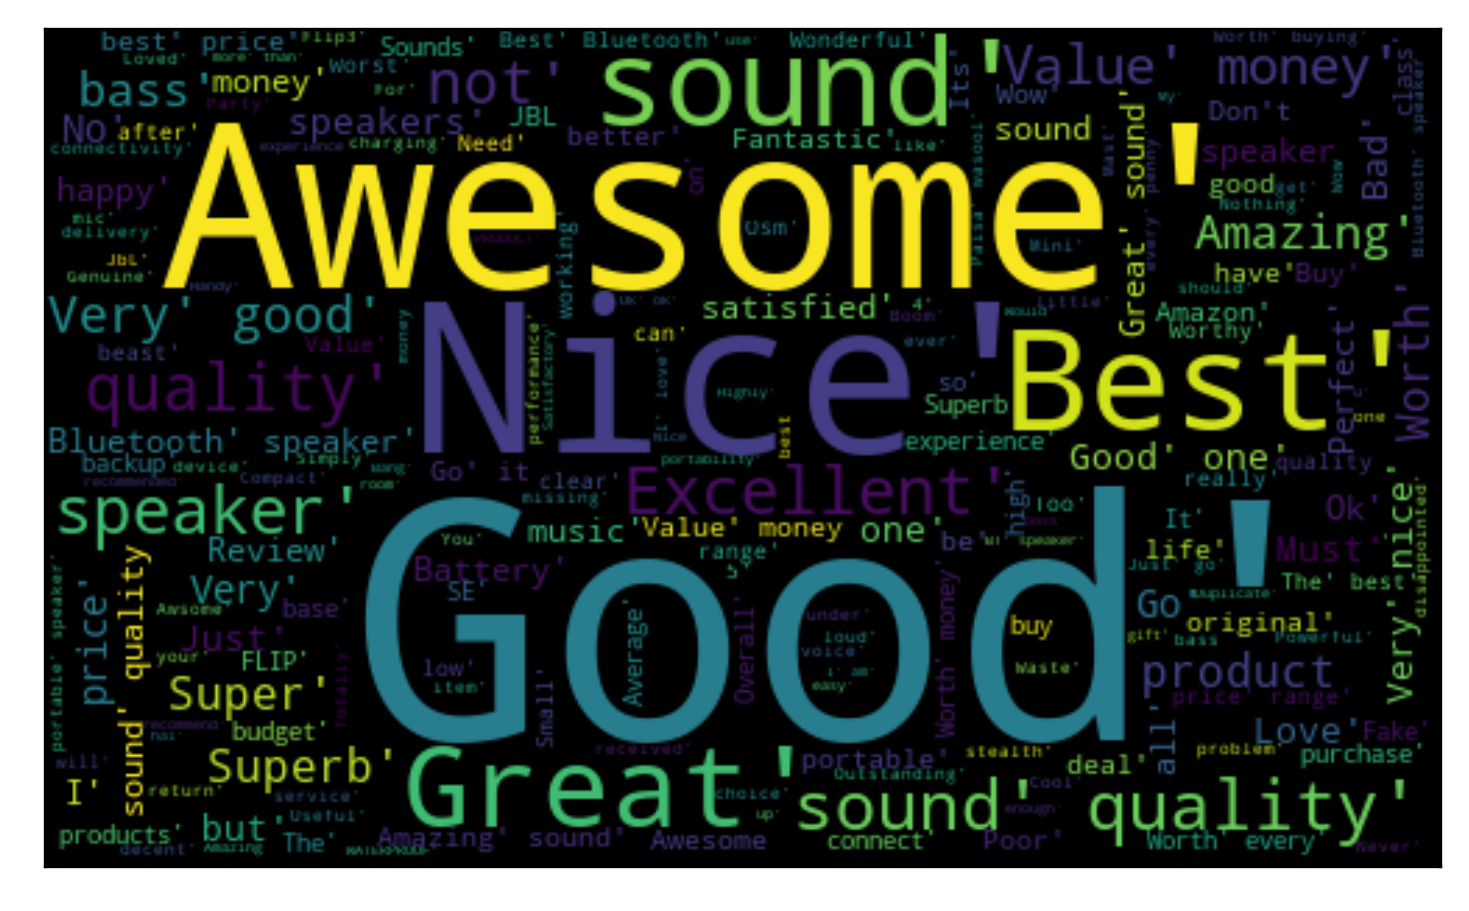

In [168]:
wordcloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 120).generate(all_words)
plt.imshow(wordcloud, interpolation= "bilinear")
plt.xticks([])
plt.yticks([])
plt.show()

From the word cloud we can see that all max repeated words are positive(like: Good, Awesome, Nice, Best, Great, Superb, etc) so even this analysis shows that jbl is a very good product.

<hr>

__`Conclussion`__: From all the above analysis we can conclude that max people are satisfied with the                     product and from all the above observations we can observe that almost 80% of data is                 in positive side of the product and comsumers are happy with it.

__Hence its an excellent product and we can proceed to buy it.__

<hr>